In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/womenintheloop-data-science-hackathon/train.csv
/kaggle/input/womenintheloop-data-science-hackathon/test_QkPvNLx.csv
/kaggle/input/womenintheloop-data-science-hackathon/sample_submission_pn2DrMq.csv


In [68]:
# Change your location
train = pd.read_csv('/kaggle/input/womenintheloop-data-science-hackathon/train.csv')
test = pd.read_csv('/kaggle/input/womenintheloop-data-science-hackathon/test_QkPvNLx.csv')
sample = pd.read_csv('/kaggle/input/womenintheloop-data-science-hackathon/sample_submission_pn2DrMq.csv')

In [69]:
# Columns of the data set
print(list(train.columns))
print(list(test.columns))

['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic', 'Competition_Metric', 'Sales']
['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'Competition_Metric']


In [70]:
print(train.shape)
print(test.shape)

(512087, 11)
(36000, 9)


In [71]:
# We notice that User Traffic in the train set is missing in the test data
# Lets analyse each parameter

In [72]:
train.ID.nunique()

512087

In [73]:
train.apply(lambda x : len(x.unique()))

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       197
Sales                    544
dtype: int64

In [74]:
# Notice that ID is unique for each data point, So removing can remove it 

In [75]:
del train['ID']
del test['ID']

In [76]:
# Sales is the target variable and its a regression problem, lets further analyse sales

In [77]:
train.Sales.describe() # 

count    512087.000000
mean        120.826924
std          54.355258
min           0.000000
25%          84.000000
50%         111.000000
75%         146.000000
max         682.000000
Name: Sales, dtype: float64

In [78]:
# From the description of sales, we find that minimum sales is 0 which is not possible

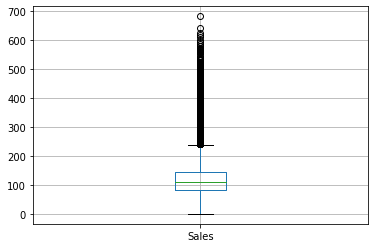

In [79]:
train[['Sales']].boxplot()

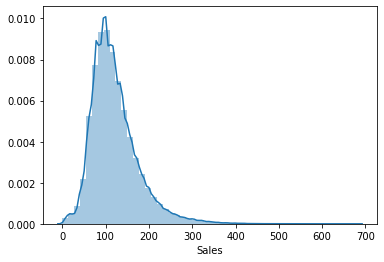

In [80]:
sns.distplot(train['Sales'])

In [81]:
# From the distribution of we can find that
# Sales do not follow normal distribution
# Sales is postively skewed

In [82]:
print("Skewness= ", train['Sales'].skew())
print("Kurtosis= ", train['Sales'].kurt())

Skewness=  1.374769816079381
Kurtosis=  3.6095060518605546


In [83]:
# Since kutosis is > 3, we can conclude that Distribution is longer, has Many Outliers

In [84]:
# Analysis of Day_Number

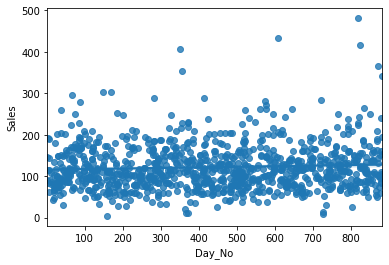

In [85]:
# plotting on sample of dataset coz data is huge 
sampletrain= train.sample(1000)
sns.regplot(x='Day_No',y='Sales',data= sampletrain)

In [86]:
# As we can see from the above graph, We can say that Day_No is not a good estimator

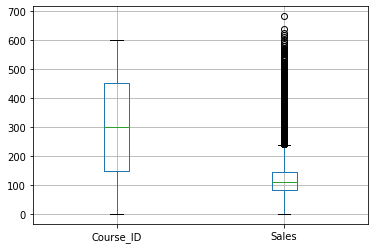

In [87]:
train[['Course_ID','Sales']].boxplot()

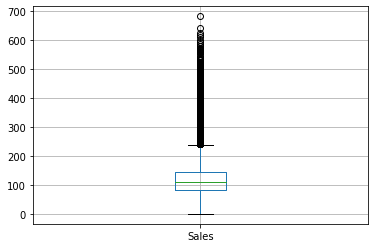

In [88]:
train[['Course_Domain','Sales']].boxplot()

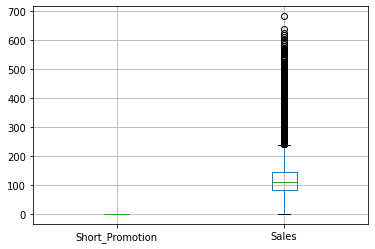

In [89]:
train[['Short_Promotion','Sales']].boxplot()

In [90]:
# From the above graphs we can conclude that data can be normalised before fiting it into a models

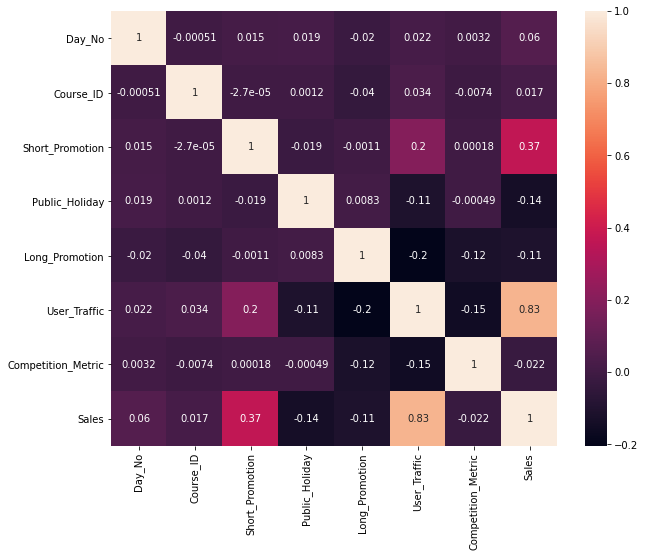

In [91]:
# Lets find the correlation
plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot= True)

In [92]:
train.corr().unstack().sort_values().drop_duplicates()

User_Traffic        Long_Promotion       -0.204289
Competition_Metric  User_Traffic         -0.148775
Public_Holiday      Sales                -0.135052
Long_Promotion      Competition_Metric   -0.119382
Sales               Long_Promotion       -0.109455
Public_Holiday      User_Traffic         -0.108305
Long_Promotion      Course_ID            -0.039605
Sales               Competition_Metric   -0.022085
Day_No              Long_Promotion       -0.020204
Short_Promotion     Public_Holiday       -0.018770
Competition_Metric  Course_ID            -0.007385
Short_Promotion     Long_Promotion       -0.001149
Course_ID           Day_No               -0.000506
Competition_Metric  Public_Holiday       -0.000491
Course_ID           Short_Promotion      -0.000027
Competition_Metric  Short_Promotion       0.000182
Public_Holiday      Course_ID             0.001242
Day_No              Competition_Metric    0.003229
Public_Holiday      Long_Promotion        0.008319
Day_No              Short_Promo

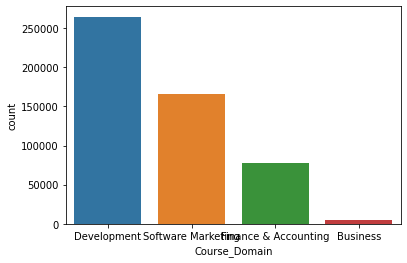

In [93]:
sns.countplot(train['Course_Domain'])

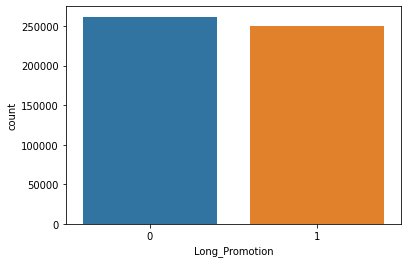

In [94]:
sns.countplot(train['Long_Promotion'])

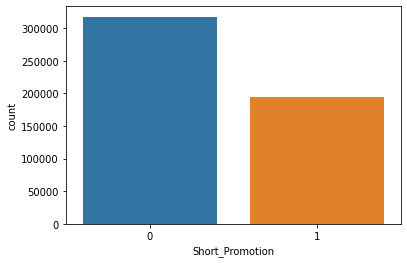

In [95]:
sns.countplot(train['Short_Promotion'])

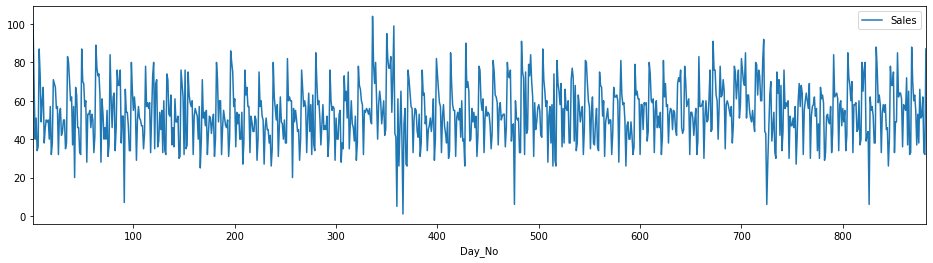

In [96]:
sample_train = train[train.Sales>0] # Sales cannot be zero
sample_train[sample_train['Course_ID']==132][['Day_No','Sales']].plot(x='Day_No',y='Sales',figsize=(16,4))

In [97]:
avg_sales = train.groupby(['Course_ID','Course_Domain','Course_Type','Short_Promotion','Public_Holiday','Long_Promotion'])['Sales'].mean().reset_index()

Adding a new feature by using Day_No 

In [98]:
def day_to_date(dataset):
    start = date(2018,12,31)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + timedelta(x)) 

def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)

In [99]:
day_to_date(train)
day_month_year(train)
day_to_date(test)
day_month_year(test)

Since test doesnt contain User Traffic, we are removing it

In [100]:
train.drop('User_Traffic',axis =1, inplace = True)

In [128]:
print(train.columns)
print(test.columns)

Index(['Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Sales', 'Date', 'Day', 'Month', 'Year'],
      dtype='object')
Index(['Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Date', 'Day', 'Month', 'Year'],
      dtype='object')


In [102]:
# merge train and test
df = train.append(test)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [103]:
df.isna().sum()

Competition_Metric     1884
Course_Domain             0
Course_ID                 0
Course_Type               0
Date                      0
Day                       0
Day_No                    0
Long_Promotion            0
Month                     0
Public_Holiday            0
Sales                 36000
Short_Promotion           0
Year                      0
dtype: int64

In [104]:
df['Competition_Metric'].fillna(df['Competition_Metric'].median(), inplace = True)

In [129]:
df1=pd.get_dummies(df,columns=['Course_Domain','Course_Type'],drop_first=True)

In [130]:
df1.columns


Index(['Competition_Metric', 'Course_ID', 'Date', 'Day', 'Day_No',
       'Long_Promotion', 'Month', 'Public_Holiday', 'Sales', 'Short_Promotion',
       'Year', 'Course_Domain_Development',
       'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')

In [131]:
df1.drop(['Day_No','Date'],axis = 1,inplace = True)

In [132]:
#splitting train and test from df
train1= df1[df1['Sales'].isnull()!= True]
test1= df1[df1['Sales'].isnull()== True].drop(['Sales'], axis=1)
print(train1.shape)
print(test1.shape)

(512087, 14)
(36000, 13)


In [133]:
print(train1.columns)
print(test1.columns)

Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Sales', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')
Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')


In [134]:
X_train = train1.drop('Sales',axis = 1)
Y_train = train.Sales
X_test = test1

In [137]:
print(X_train.columns)
print(Y_train)
print(X_test.columns)


Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')
0          81
1          79
2          75
3          80
4          41
         ... 
512082    114
512083    145
512084    167
512085    107
512086    152
Name: Sales, Length: 512087, dtype: int64
Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')


In [140]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 890)

In [122]:
print(X_train.columns)
print(X_test.columns)

Index(['Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'Competition_Metric', 'Day',
       'Month', 'Year'],
      dtype='object')
Index(['Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'Competition_Metric', 'Day',
       'Month', 'Year'],
      dtype='object')


In [143]:
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)

In [144]:
from hyperopt import STATUS_OK 
from hyperopt import hp 
from hyperopt import tpe 
from hyperopt import fmin 
from hyperopt import Trials

N_FOLDS = 5

In [149]:
 from sklearn.metrics import mean_squared_log_error

In [145]:
def rmsle(preds, lgb_train): 
    eval_name = 'rmsle' 
    eval_result = np.sqrt(mean_squared_log_error(preds, lgb_train.get_label())) 
    return (eval_name, eval_result*1000, False)

In [146]:
def objective(params, n_folds = N_FOLDS): 
    cv_results = lgb.cv(params, lgb_train, num_boost_round = 1000, nfold = 5, feval = rmsle, early_stopping_rounds = 10, seed = 50) 
    best_score = min(cv_results['rmsle-mean']) 
    return {'loss': best_score, 'params': params, 'status': STATUS_OK}

In [147]:
space = { 'task': hp.choice('task', ['train']), 'objective': hp.choice('objective', ['gamma']), 'metric' : hp.choice('metric', ['None']), 'boosting': hp.choice('boosting', ['gbdt']), 'learning_rate': hp.loguniform('learning_rate',np.log(0.003), np.log(0.5)), 'num_leaves': hp.choice('num_leaves', range(2, 100, 5)), 'max_depth': hp.choice('max_depth', range(1, 30, 5)), 'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1.0), 'bagging_freq': hp.choice('bagging_freq', range(1, 10, 1)), 'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0), 'max_bin': hp.choice('max_bin', range(200, 256, 5)), 'min_data_in_leaf': hp.choice('min_data_in_leaf', range(10, 1000, 1)), 'subsample': hp.uniform('subsample', 0.1, 1.0), 'bagging_seed': hp.choice('bagging_seed', range(1, 10, 1)), 'feature_fraction_seed': hp.choice('feature_fraction_seed', range(1, 10, 1)), }

In [151]:
evals_result = {} 
params = {
        'task': 'train',
        'objective': 'gamma',
        'metric' : 'None',
        'boosting': 'gbdt',
        'learning_rate': 0.03,
        'num_leaves': 100,
        'bagging_fraction': 0.85,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'n_estimators': 1000,
    }
def rmsle(preds, lgb_train):
    eval_name = "rmsle"
    eval_result = np.sqrt(mean_squared_log_error(preds, lgb_train.get_label()))
    return (eval_name, eval_result*1000, False)


cv_results = lgb.cv(params, lgb_train, num_boost_round = 1000, nfold = 5, feval = rmsle, early_stopping_rounds = 10, verbose_eval = 100, seed = 50)

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, feval = rmsle,  evals_result = evals_result, verbose_eval = 100)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[100]	cv_agg's rmsle: 268.456 + 1.69716
[200]	cv_agg's rmsle: 212.184 + 1.181
[300]	cv_agg's rmsle: 191.548 + 0.635463
[400]	cv_agg's rmsle: 181.547 + 0.597945
[500]	cv_agg's rmsle: 174.949 + 0.44322
[600]	cv_agg's rmsle: 170.231 + 0.632127
[700]	cv_agg's rmsle: 166.309 + 0.562697
[800]	cv_agg's rmsle: 163.207 + 0.590796
[900]	cv_agg's rmsle: 160.807 + 0.592805
[1000]	cv_agg's rmsle: 158.644 + 0.619614


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's rmsle: 269.069
[200]	valid_0's rmsle: 212.104
[300]	valid_0's rmsle: 190.61
[400]	valid_0's rmsle: 180.996
[500]	valid_0's rmsle: 174.451
[600]	valid_0's rmsle: 169.647
[700]	valid_0's rmsle: 165.447
[800]	valid_0's rmsle: 162.2
[900]	valid_0's rmsle: 159.618
[1000]	valid_0's rmsle: 157.466


In [152]:
predictions = lgbm_model.predict(X_test)


In [154]:
len(predictions)

36000

In [155]:
sample['Sales'] = predictions

In [158]:
sample # Submission 1

,ID,Sales
0,883,138.999227
1,884,122.258686
2,885,128.462012
3,886,111.747664
4,887,78.765086
...,...,...
35995,548083,136.801530
35996,548084,140.762869
35997,548085,140.538499
35998,548086,155.552493


In [157]:
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [159]:
def rmsle1000(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000

In [161]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [163]:
#xgb
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)

X_train = train1.drop('Sales',axis = 1)
Y_train = train.Sales
X_test = test1

cv_score =[]
i=1
for train_index,test_index in kf.split(X_train, Y_train):
    print('Fold no. = ', i)
    
    x_train, x_test = X_train.loc[train_index], X_train.loc[test_index]
    y_train, y_test = Y_train.loc[train_index], Y_train.loc[test_index]
    
    #model
    xgb = XGBRegressor(n_estimators= 500)
    xgb.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle1000(y_test, y_pred)
    print('RMSLE score:',score)
    cv_score.append(score)    
    
    i+=1

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fold no. =  1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


RMSLE score: 166.25207745139713
Fold no. =  2
RMSLE score: 171.0403434250361
Fold no. =  3
RMSLE score: 168.65291980853246
Fold no. =  4
RMSLE score: 171.0715975218461
Fold no. =  5
RMSLE score: 173.14420128879627


In [167]:
xgb.feature_importances_

array([0.08600949, 0.11178765, 0.02294752, 0.16684055, 0.02101542,
       0.04465631, 0.14864011, 0.0200207 , 0.06686223, 0.05531725,
       0.04534302, 0.12524882, 0.08531087], dtype=float32)

In [168]:
xgb = XGBRegressor(n_estimators= 500)
xgb.fit(X_train,Y_train)
xgb_preds = xgb.predict(X_test)

In [169]:
# for submission
lgbm = LGBMRegressor(n_estimators= 500)
lgbm.fit(X_train, Y_train)
lgbm_preds = lgbm.predict(X_test)

In [170]:
print(xgb_preds)

[157.46783 131.5456  134.97292 ... 145.67209 162.35298 154.07933]


In [171]:
print(lgbm_preds)

[159.83323991 132.97323577 130.61979888 ... 143.05420148 164.65330463
 160.47933612]


In [175]:
print(train1.columns)
print(test1.columns)

Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Sales', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')
Index(['Competition_Metric', 'Course_ID', 'Day', 'Long_Promotion', 'Month',
       'Public_Holiday', 'Short_Promotion', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')


In [176]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
train = h2o.H2OFrame(train1)
test = h2o.H2OFrame(test1)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_242"; OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-1~deb9u1-b08); OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpphg5h_o3
  JVM stdout: /tmp/tmpphg5h_o3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpphg5h_o3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_unknownUser_hyybgw
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [178]:
y = "Sales"
x = list(X_train.columns)
aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = train)
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows)
preds = aml.predict(test)
water_preds=h2o.as_list(preds) 

AutoML progress: |████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [179]:
water_preds

,predict
0,129.441467
1,117.600060
2,118.426071
3,114.954758
4,80.281784
...,...
35995,139.160446
35996,136.158951
35997,129.224380
35998,149.668839


In [189]:
sample.rename(columns = {'Sales':'Sales_by_lgbm'},inplace = True)

In [191]:
sample['XG Boost'] = xgb_preds

In [192]:
sample['LightGBM'] = lgbm_preds

In [193]:
sample['H20'] = water_preds

In [194]:
#Predictions of various modles
sample

,ID,Sales_by_lgbm,XG Boost,LightGBM,H20
0,883,138.999227,157.467834,159.833240,129.441467
1,884,122.258686,131.545593,132.973236,117.600060
2,885,128.462012,134.972916,130.619799,118.426071
3,886,111.747664,95.859680,111.089157,114.954758
4,887,78.765086,74.381004,81.514992,80.281784
...,...,...,...,...,...
35995,548083,136.801530,167.271210,143.585393,139.160446
35996,548084,140.762869,141.053360,145.251875,136.158951
35997,548085,140.538499,145.672089,143.054201,129.224380
35998,548086,155.552493,162.352982,164.653305,149.668839
